In [1]:
import ast
import datasets
import json
# import evaluate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, BertTokenizer, DataCollatorWithPadding, EvalPrediction
from sklearn.model_selection import train_test_split

c:\Users\mathi\Prosjekter\Barcelona\HLE\HLE-Project\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())
device = "cuda:0" if torch.cuda.is_available() else "cpu"

True


In [3]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

# NB: Quick Fix of late-found data leakage
We found out very close to the deadline that our preprocessing had a data leakage, where the keywords from the data-scraping would contain the actual target label. Therefore they are hidden inside the text.

We therefore remove all of these occurrences.

In [4]:
labels = [label for label in train_df.columns if label != 'text']
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in enumerate(labels)}
labels

['nyheter',
 'tema',
 'sport',
 'kjendis',
 'kultur',
 'meninger',
 'annonse',
 'bok',
 'magasinet',
 'okonomi']

In [5]:
train_df

,nyheter,tema,sport,kjendis,kultur,meninger,annonse,bok,magasinet,okonomi,text
0,0,0,0,0,0,1,0,0,0,0,Overskrift: en lek med ilden. Oppsummering: Ba...
1,0,0,0,1,0,0,0,0,0,0,Overskrift: apner seg om morsrollen. Oppsummer...
2,0,0,1,0,0,0,0,0,0,0,Overskrift: tatt pa senga. Oppsummering: Måten...
3,0,0,1,0,0,0,0,0,0,0,Overskrift: kjopt ut fra familieselskapet. Opp...
4,1,0,0,0,0,0,0,0,0,0,Overskrift: gjor den skitne jobben. Oppsummeri...
...,...,...,...,...,...,...,...,...,...,...,...
13591,1,0,0,0,0,0,0,0,0,0,Overskrift: syntes det var hjerteratt. Oppsumm...
13592,0,1,0,0,0,0,0,0,0,0,Overskrift: dode av samme sykdom. Oppsummering...
13593,1,0,0,0,0,0,0,0,0,0,Overskrift: innestengt i 39 dager skremmende. ...
13594,0,0,1,0,0,0,0,0,0,0,Overskrift: sterke reaksjoner sjokkert. Oppsu...


In [6]:
for i in range(len(train_df)):
    text = train_df.loc[i, 'text']
    text_list = text.split(".")
    for t in text_list:
        if " Nøkkelord:" in t:
            text_list.remove(t)
    train_df.loc[i, 'text'] = ".".join(text_list)

for i in range(len(test_df)):
    text = test_df.loc[i, 'text']
    text_list = text.split(".")
    for t in text_list:
        if " Nøkkelord:" in t:
            text_list.remove(t)
    test_df.loc[i, 'text'] = ".".join(text_list)

In [7]:
# Remove all occurrences of labels within every row of the text column
for label in labels:
    train_df['text'] = train_df['text'].str.replace(label, '')
    test_df['text'] = test_df['text'].str.replace(label, '')

In [8]:
for label in labels:
    for i in range(len(train_df)):
        text = train_df.loc[i, 'text']
        assert label not in text
    for i in range(len(test_df)):
        text = test_df.loc[i, 'text']
        assert label not in text

In [9]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    cross_entropy = torch.nn.CrossEntropyLoss()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    ce_loss = cross_entropy(torch.Tensor(y_true), torch.Tensor(y_pred))
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get('logits')
    loss_fct = torch.nn.CrossEntropyLoss()
    loss = loss_fct(logits.squeeze(), labels.squeeze())
    return (loss, outputs) if return_outputs else loss

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(
    "NbAiLab/nb-bert-large",
    problem_type="multi_label_classification",
    num_labels=len(labels), 
    id2label=id2label, 
    label2id=label2id
)

model = model.share_memory().to(device)

Some weights of the model checkpoint at NbAiLab/nb-bert-large were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

In [11]:
tokenizer = BertTokenizer.from_pretrained("NbAiLab/nb-bert-large")

In [12]:
def preprocess_data(examples):
  # take a batch of texts
  text = examples["text"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=64)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

In [13]:
train = datasets.Dataset.from_pandas(train_df)
test = datasets.Dataset.from_pandas(test_df)
encoded_train = train.map(preprocess_data, batched=True, remove_columns=train.column_names)
encoded_test = test.map(preprocess_data, batched=True, remove_columns=test.column_names)
encoded_train.set_format("torch")
encoded_test.set_format("torch")

100%|██████████| 4/4 [00:03<00:00,  1.16ba/s]


In [14]:
encoded_train

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 13596
})

In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [16]:
batch_size = 16
metric_name = "f1"

In [17]:
training_args = TrainingArguments(
    output_dir="E:\\Pytorch\\Saved_Models\\CLASSIFICATION_MODEL",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    metric_for_best_model=metric_name,
)

class ClassificationTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.squeeze(), labels.squeeze())
        return (loss, outputs) if return_outputs else loss

trainer = ClassificationTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [18]:
example = encoded_train[0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [19]:
tokenizer.decode(example['input_ids'])

'[CLS] overskrift : en lek med ilden. oppsummering : bataljen mellom aftenposten og hadia tajik illustrerer at pressen og politikere har et stort ansvar for å forvalte tilliten mellom dem. særlig av hensyn til hvordan omverdenen oppfatter forholdet. personer : hadia tajik, geir ramnefjell. organisasjoner : aftenposten. spådd [SEP]'

In [20]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['meninger']

In [21]:
trainer.train()

c:\Users\mathi\Prosjekter\Barcelona\HLE\HLE-Project\venv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 13596
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2550
  Number of trainable parameters = 355097610
 20%|█▉        | 500/2550 [03:23<13:24,  2.55it/s]

{'loss': 0.6243, 'learning_rate': 1.607843137254902e-05, 'epoch': 0.59}


 33%|███▎      | 850/2550 [05:41<10:42,  2.65it/s]***** Running Evaluation *****
  Num examples = 3399
  Batch size = 16
                                                  
 33%|███▎      | 850/2550 [05:59<10:42,  2.65it/s]

{'eval_loss': 0.2846260070800781, 'eval_f1': 0.4738724836922214, 'eval_roc_auc': 0.8746526756235494, 'eval_accuracy': 0.0088261253309797, 'eval_runtime': 18.6794, 'eval_samples_per_second': 181.966, 'eval_steps_per_second': 11.403, 'epoch': 1.0}


Saving model checkpoint to E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-850
Configuration saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-850\config.json
Model weights saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-850\pytorch_model.bin
tokenizer config file saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-850\tokenizer_config.json
Special tokens file saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-850\special_tokens_map.json
 39%|███▉      | 1000/2550 [07:27<11:18,  2.28it/s] 

{'loss': 0.3013, 'learning_rate': 1.215686274509804e-05, 'epoch': 1.18}


 59%|█████▉    | 1500/2550 [11:05<07:42,  2.27it/s]

{'loss': 0.2054, 'learning_rate': 8.23529411764706e-06, 'epoch': 1.76}


 67%|██████▋   | 1700/2550 [12:33<05:48,  2.44it/s]***** Running Evaluation *****
  Num examples = 3399
  Batch size = 16
                                                   
 67%|██████▋   | 1700/2550 [12:53<05:48,  2.44it/s]

{'eval_loss': 0.29035302996635437, 'eval_f1': 0.5956395092241151, 'eval_roc_auc': 0.921856101467752, 'eval_accuracy': 0.20388349514563106, 'eval_runtime': 19.5071, 'eval_samples_per_second': 174.245, 'eval_steps_per_second': 10.919, 'epoch': 2.0}


Saving model checkpoint to E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-1700
Configuration saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-1700\config.json
Model weights saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-1700\pytorch_model.bin
tokenizer config file saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-1700\tokenizer_config.json
Special tokens file saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-1700\special_tokens_map.json
 78%|███████▊  | 2000/2550 [15:12<03:33,  2.58it/s]  

{'loss': 0.1313, 'learning_rate': 4.313725490196079e-06, 'epoch': 2.35}


 98%|█████████▊| 2500/2550 [18:24<00:18,  2.67it/s]

{'loss': 0.1055, 'learning_rate': 3.921568627450981e-07, 'epoch': 2.94}


100%|██████████| 2550/2550 [18:43<00:00,  2.74it/s]***** Running Evaluation *****
  Num examples = 3399
  Batch size = 16
                                                   
100%|██████████| 2550/2550 [19:01<00:00,  2.74it/s]Saving model checkpoint to E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-2550


{'eval_loss': 0.3220588266849518, 'eval_f1': 0.6933470861268695, 'eval_roc_auc': 0.9464384949821842, 'eval_accuracy': 0.4145336863783466, 'eval_runtime': 17.6191, 'eval_samples_per_second': 192.916, 'eval_steps_per_second': 12.089, 'epoch': 3.0}


Configuration saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-2550\config.json
Model weights saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-2550\pytorch_model.bin
tokenizer config file saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-2550\tokenizer_config.json
Special tokens file saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-2550\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\checkpoint-2550 (score: 0.6933470861268695).
100%|██████████| 2550/2550 [19:26<00:00,  2.19it/s]

{'train_runtime': 1166.4973, 'train_samples_per_second': 34.966, 'train_steps_per_second': 2.186, 'train_loss': 0.2698802349614162, 'epoch': 3.0}


TrainOutput(global_step=2550, training_loss=0.2698802349614162, metrics={'train_runtime': 1166.4973, 'train_samples_per_second': 34.966, 'train_steps_per_second': 2.186, 'train_loss': 0.2698802349614162, 'epoch': 3.0})

In [22]:
trainer.save_model("E:\\Pytorch\\Saved_Models\\CLASSIFICATION_MODEL\\FINAL4")

Saving model checkpoint to E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\FINAL4
Configuration saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\FINAL4\config.json
Model weights saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\FINAL4\pytorch_model.bin
tokenizer config file saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\FINAL4\tokenizer_config.json
Special tokens file saved in E:\Pytorch\Saved_Models\CLASSIFICATION_MODEL\FINAL4\special_tokens_map.json


# Evaluation & Prediction

In [23]:
predictions, true_labels, _ = trainer.predict(encoded_test)

***** Running Prediction *****
  Num examples = 3399
  Batch size = 16
100%|██████████| 213/213 [00:20<00:00, 10.54it/s]


In [24]:
%%capture capture
def eval(predictions, labels, verbose: bool=False, threshold: float=0.5):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.argmax(probs.numpy(), axis=1)
    y_true = np.argmax(labels, axis=1)
    target_names = [id2label[i] for i in np.unique(y_true)]
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
    correct = np.sum(y_true == y_pred)
    wrong = np.sum(y_true != y_pred)
    print(f"Correct answers: {correct}. Wrong answers: {wrong}")
    print(f"Percentage of correct answers: {round(correct/(correct+wrong) * 100, 2)}%")

eval(predictions, true_labels, verbose=False)

In [25]:
with open('report.txt', 'w') as f:
    f.write(capture.stdout)

In [26]:
# Visualize the columns from train_df in a bar chart
training_counts = {}
for column in train_df.columns:
    if column != 'text':
        training_counts[column] = train_df[column].sum()

testing_counts = {}
for column in test_df.columns:
    if column != 'text':
        testing_counts[column] = test_df[column].sum()


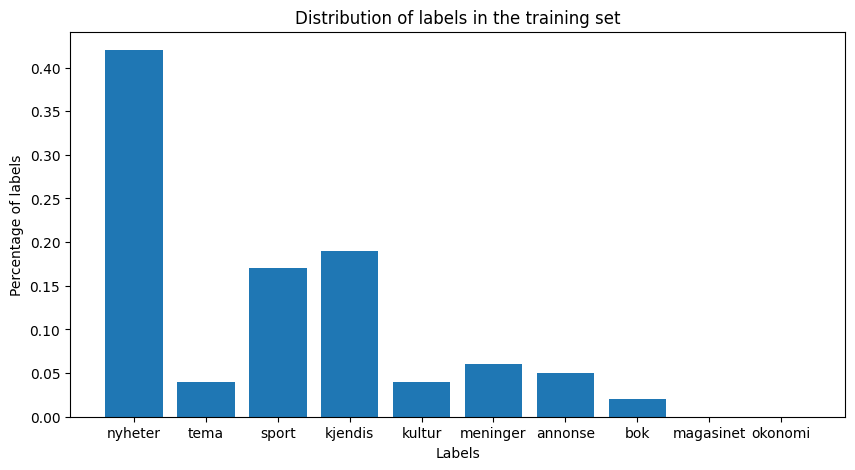

In [27]:
# Normalize
for key in training_counts.keys():
    training_counts[key] = round(training_counts[key] / len(train_df), 2)
# Plot the values in a bar chart
plt.figure(figsize=(10, 5))
plt.bar(training_counts.keys(), training_counts.values())
plt.title("Distribution of labels in the training set")
plt.xlabel("Labels")
plt.ylabel("Percentage of labels")
plt.savefig('figures/training_label_distribution.png')
plt.show()

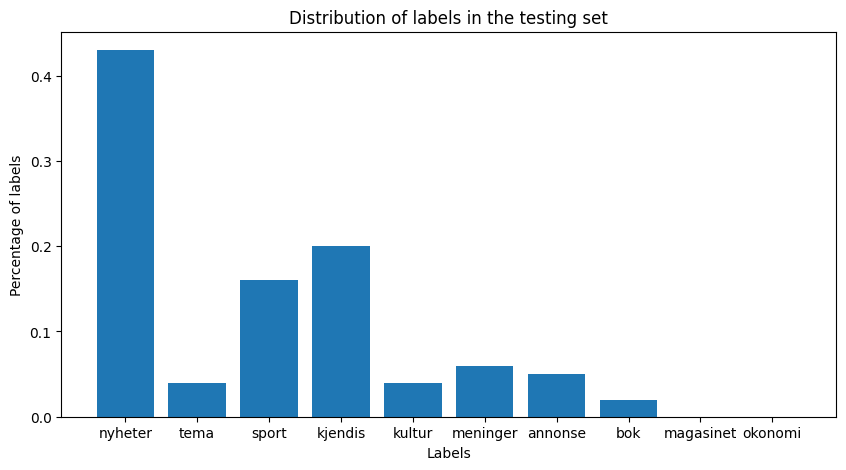

In [28]:
for key in testing_counts.keys():
    testing_counts[key] = round(testing_counts[key] / len(test_df), 2)

plt.figure(figsize=(10, 5))
plt.bar(testing_counts.keys(), testing_counts.values())
plt.title("Distribution of labels in the testing set")
plt.xlabel("Labels")
plt.ylabel("Percentage of labels")
plt.savefig('figures/testing_label_distribution.png')
plt.show()

# Evaluate on articles from NRK

In [29]:
# Links used:
# https://www.nrk.no/sport/weng-slaktar-seg-sjolv-etter-sprekk_-_-darlegaste-nokon-gang-1.16216272
# https://www.nrk.no/sport/kane-brente-straffe-da-frankrike-knuste-englands-vm-draum-1.16215885
# https://www.nrk.no/nyheter/tyskland-1.14668923
# https://www.nrk.no/trondelag/troll-of-trondheim_-ekstremvaer-i-storbritannia-kalles-troll-from-trondheim-eller-troll-of-trondheim-1.16215866

headlines = [
    "Karlsson provosert av norsk taktikk: - Ein protest",
    "England-stjerne med spark mot dommaren etter VM-exit",
    "Mistenkt gjerningsperson død i Tyskland",
    "Britisk ekstremvær har fått navnet «Troll of Trondheim»"
]

summaries = [
    "Det blei dobbelt norsk på blanda stafett på Beitostølen, og no reagerer Frida Karlsson etter lite hjelp å få fra dei norske kvinnene.",
    "England var nære ein semifinale i VM, men i staden blei det eit mareritt for kaptein Harry Kane. No reagerer spelarar og ekspertar på det dei skildrar som dårleg dømming.",
    "Den mistenkte gjerningspersonen i gisselsituasjonen i Dresden i Tyskland er død, opplyser tysk politi i ei melding på Twitter",
    "Deler av Storbritannia har fått ordentlig vintervær. Snø som blir liggende over natten og temperaturer ned mot ti kalde er ikke dagligdags for dem. I Storbritannia har kuldebølgen fått navnet «Troll of Trondheim»."
]

nrk_labels = [
    "sport",
    "sport",
    "nyheter",
    "nyheter"
]

temp_df = pd.DataFrame(columns=train_df.columns).reset_index(drop=True)

for i in range(4):
    text = f"{headlines[i]}. {summaries[i]}"
    temp_df.loc[i, "text"] = text
    temp_df.loc[i, nrk_labels[i]] = 1

temp_df.fillna(0, inplace=True)

nrk_dataset = datasets.Dataset.from_pandas(temp_df)
nrk_dataset = nrk_dataset.remove_columns(['__index_level_0__'])
encoded_nrk = nrk_dataset.map(preprocess_data, batched=True, remove_columns=nrk_dataset.column_names)

100%|██████████| 1/1 [00:00<00:00, 181.43ba/s]


In [30]:
%%capture cap
predictions, _, _ = trainer.predict(encoded_nrk)
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(predictions))
y_pred = np.argmax(probs.numpy(), axis=1)
pred_labels = [id2label[idx] for idx in y_pred]
print(f"Correct labels: {nrk_labels}")
print(f"Predicted labels: {pred_labels}")

***** Running Prediction *****
  Num examples = 4
  Batch size = 16


In [31]:
with open("example.txt", "w") as f:
    f.write(cap.stdout)